In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats  as stats
import os
from functools import reduce
import seaborn as sns

In [0]:
mark_qualified=pd.read_csv(r"/Users/emmanuelsibanda/Downloads/olist_marketing_qualified_leads_dataset.csv")
closed_deals = pd.read_csv(r"/Users/emmanuelsibanda/Downloads//olist_closed_deals_dataset.csv")
seller_data = pd.read_csv(r"/Users/emmanuelsibanda/Downloads/olist_sellers_dataset.csv")
order_list = pd.read_csv(r"/Users/emmanuelsibanda/Downloads/olist_order_items_dataset.csv")

In [0]:
merged_list = pd.merge(closed_deals,mark_qualified,on='mql_id',how='outer').fillna(0)
frames = [merged_list,seller_data,order_list]
seller_merged = reduce(lambda left, right: pd.merge(left,right,on='seller_id',how='outer'),frames).fillna(0)

In [0]:
seller_merged['time_to_close'] = pd.to_datetime(seller_merged['won_date']) - pd.to_datetime(seller_merged['first_contact_date'])

In [0]:
#extract days from time to close
seller_merged['days_to_close'] = seller_merged['time_to_close'].apply(lambda x: x.days)


In [0]:
#closing success rate by point of origin
seller_merged['closed'] =  np.where(seller_merged['won_date']!=0, "True","False")

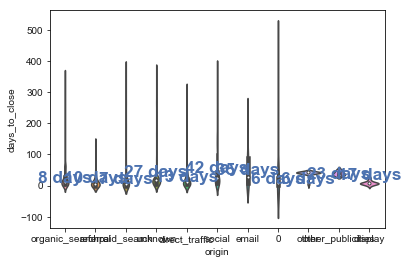

In [7]:
#length of time to close deals by origin
closing_deals = seller_merged.query('closed == "True"')
medians =  seller_merged.query('closed == "True"').groupby('origin')['days_to_close'].median().values
median_labels = [f'{m} days' for m in medians]
pos = range(len(medians))
ax = sns.violinplot(x='origin',y='days_to_close',data=closing_deals)
for tick,label in zip(pos,ax.get_xticklabels()):
  ax.text(pos[tick],medians[tick]+0.5,median_labels[tick],
         horizontalalignment='center',size='xx-large',color='b',weight='semibold')
sns.set(rc={'figure.figsize':(20,15)})



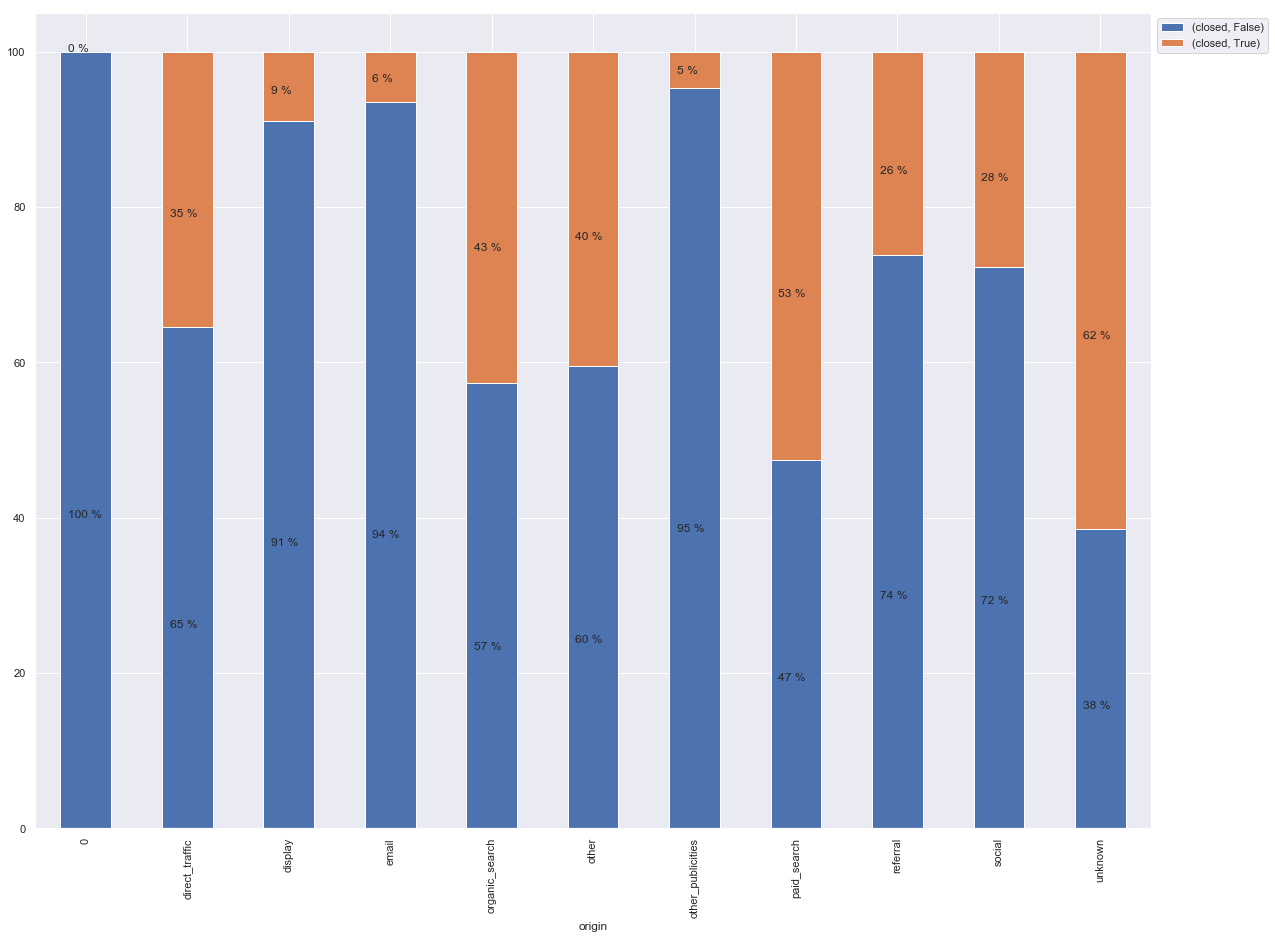

In [8]:
#percentage of deals closed/not closed by point of origin
closed_or_not = seller_merged.groupby(['origin', 'closed']).agg({'closed': 'size'})
ax = closed_or_not.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack().plot.bar(stacked=True)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    horiz_offset = 1
    vert_offset = 1
    ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
    ax.annotate('{:.0f} %'.format(height), (p.get_x()+.15*width, p.get_y()+.4*height))


In [0]:
#average value by origin
geolocation = pd.read_csv(r"/Users/emmanuelsibanda/Downloads/olist_geolocation_dataset.csv")
customer_db = pd.read_csv(r"/Users/emmanuelsibanda/Downloads/olist_customers_dataset.csv")
orders_db = pd.read_csv(r"/Users/emmanuelsibanda/Downloads/olist_orders_dataset.csv")
#merge on zip code
geolocation = geolocation.rename(columns={'geolocation_zip_code_prefix':'zip_code'})
customer_db = customer_db.rename(columns={'customer_zip_code_prefix':'zip_code'})
seller_merged = seller_merged.rename(columns={'seller_zip_code_prefix':'zip_code'})
#crashing my ram
seller_customer = pd.merge(seller_merged,customer_db,on='zip_code',how='outer').fillna(0)


In [0]:
#unique identifiers for duplicate zero values
seller_customer['customer_id'] =seller_customer['customer_id'].mask(seller_customer['customer_id'] == 0 , seller_customer['customer_id'].eq(0).cumsum())

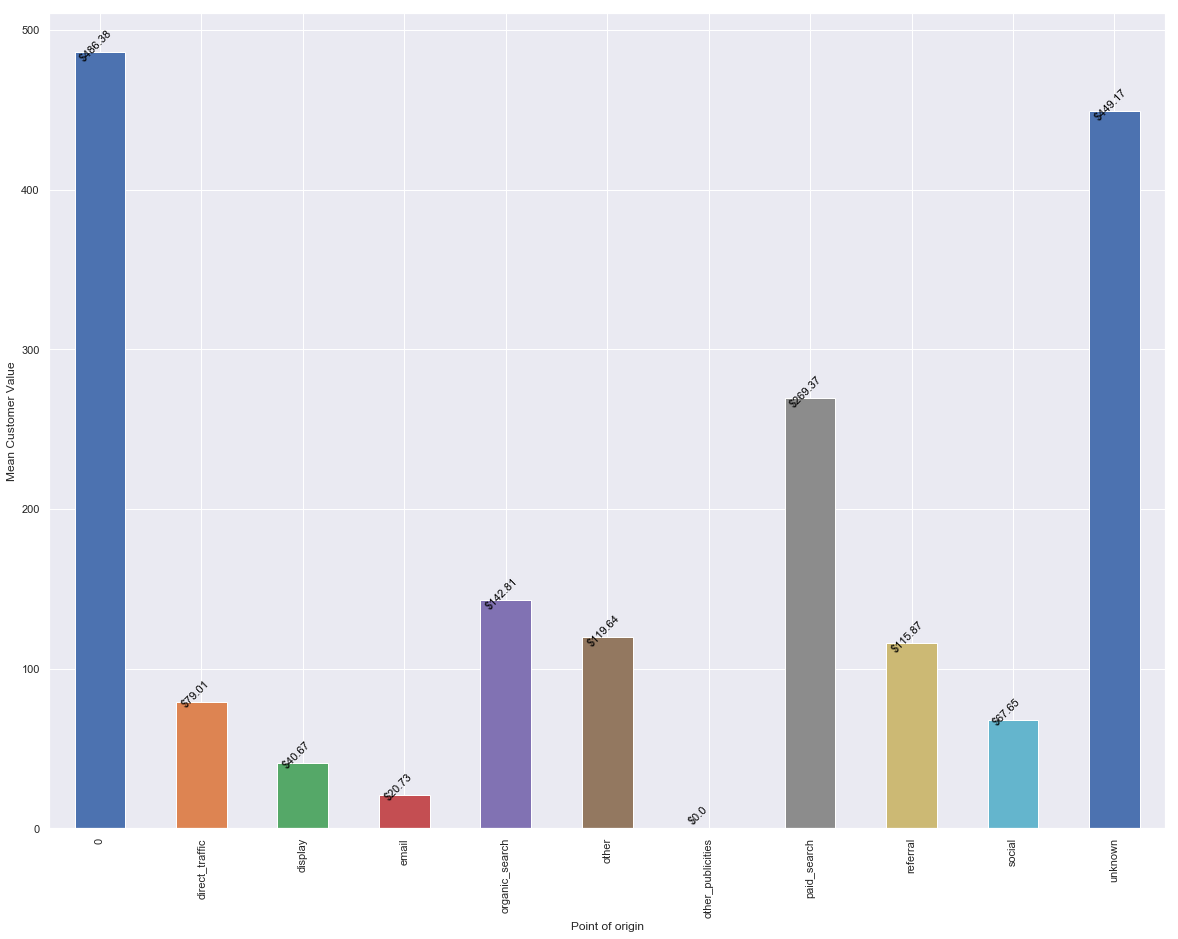

In [11]:
#currency conversions
seller_customer['usd_price'] = seller_customer['price'].apply(lambda x: x*0.26)
seller_db = pd.DataFrame(seller_customer.groupby(['origin','customer_id'])['usd_price'].sum()).reset_index()
ax_chart = seller_db.groupby('origin')['usd_price'].mean().plot.bar()
ax_chart.set_xlabel("Point of origin")
ax_chart.set_ylabel("Mean Customer Value")
for x in ax_chart.patches:
  ax_chart.text(x.get_x()+.04,x.get_height()+10,\
               f'${round(x.get_height(),2)}',fontsize=11,color='black',
               rotation=45)


In [0]:
#time to deliver orders
seller_customer = pd.merge(seller_customer,orders_db,on='customer_id',how='outer').fillna(0)


In [0]:
def reformat_date(df, column):
  df[column] = pd.to_datetime(df[column])
reformat_date(seller_customer,'order_purchase_timestamp')
reformat_date(seller_customer,'order_approved_at')
reformat_date(seller_customer,'order_delivered_carrier_date')
reformat_date(seller_customer,'order_delivered_customer_date')
reformat_date(seller_customer,'order_estimated_delivery_date')

In [0]:
seller_customer['purchase_to_approval'] =(seller_customer['order_approved_at']-seller_customer['order_purchase_timestamp']).apply(lambda x: x.total_seconds()//3600)
seller_customer['time_to_completion'] =(seller_customer['order_delivered_customer_date']-seller_customer['order_purchase_timestamp']).apply(lambda x: x.total_seconds()//3600)
seller_customer['estimated_actual'] =(seller_customer['order_estimated_delivery_date']-seller_customer['order_delivered_customer_date']).apply(lambda x: x.total_seconds()//3600)

In [0]:
#filter zero values
seller_customer2 = seller_customer.query("time_to_completion > 0 & estimated_actual > 0")


In [0]:
seller_customer2['customer_state'] =seller_customer2['customer_state'].map({'AC':'Acre','AL':'Alagoas','AM':'Amazonas','AP':'Amapá','BA':'Bahia',
                                                         'CE':'Ceará','DF':'Distrito Federal','ES':'Espírito Santo','GO':'Goiás',
                                                         'MA':'Maranhão','MG':'Minas Gerais','MS':'MatoGrosso do Sul','MT':'MatoGrosso',
                                                         'PA':'Pará','PB':'Paraíba','PE':'Pernambuco','PI':'Piauí','PR':'Paraná',
                                                         'RJ':'Rio de Janeiro','RN':'Rio Grande do Norte','RO':'Rondônia',
                                                         'RR':'Roraima','RS':'Rio Grande do Sul','SC':'Santa Catarina',
                                                         'SE':'Sergipe','SP':'São Paulo','TO':'Tocantins'})

[Text(0,0,'Acre'),
 Text(0,0,'Alagoas'),
 Text(0,0,'Amapá'),
 Text(0,0,'Amazonas'),
 Text(0,0,'Bahia'),
 Text(0,0,'Ceará'),
 Text(0,0,'Distrito Federal'),
 Text(0,0,'Espírito Santo'),
 Text(0,0,'Goiás'),
 Text(0,0,'Maranhão'),
 Text(0,0,'MatoGrosso'),
 Text(0,0,'MatoGrosso do Sul'),
 Text(0,0,'Minas Gerais'),
 Text(0,0,'Paraná'),
 Text(0,0,'Paraíba'),
 Text(0,0,'Pará'),
 Text(0,0,'Pernambuco'),
 Text(0,0,'Piauí'),
 Text(0,0,'Rio Grande do Norte'),
 Text(0,0,'Rio Grande do Sul'),
 Text(0,0,'Rio de Janeiro'),
 Text(0,0,'Rondônia'),
 Text(0,0,'Roraima'),
 Text(0,0,'Santa Catarina'),
 Text(0,0,'Sergipe'),
 Text(0,0,'São Paulo'),
 Text(0,0,'Tocantins')]

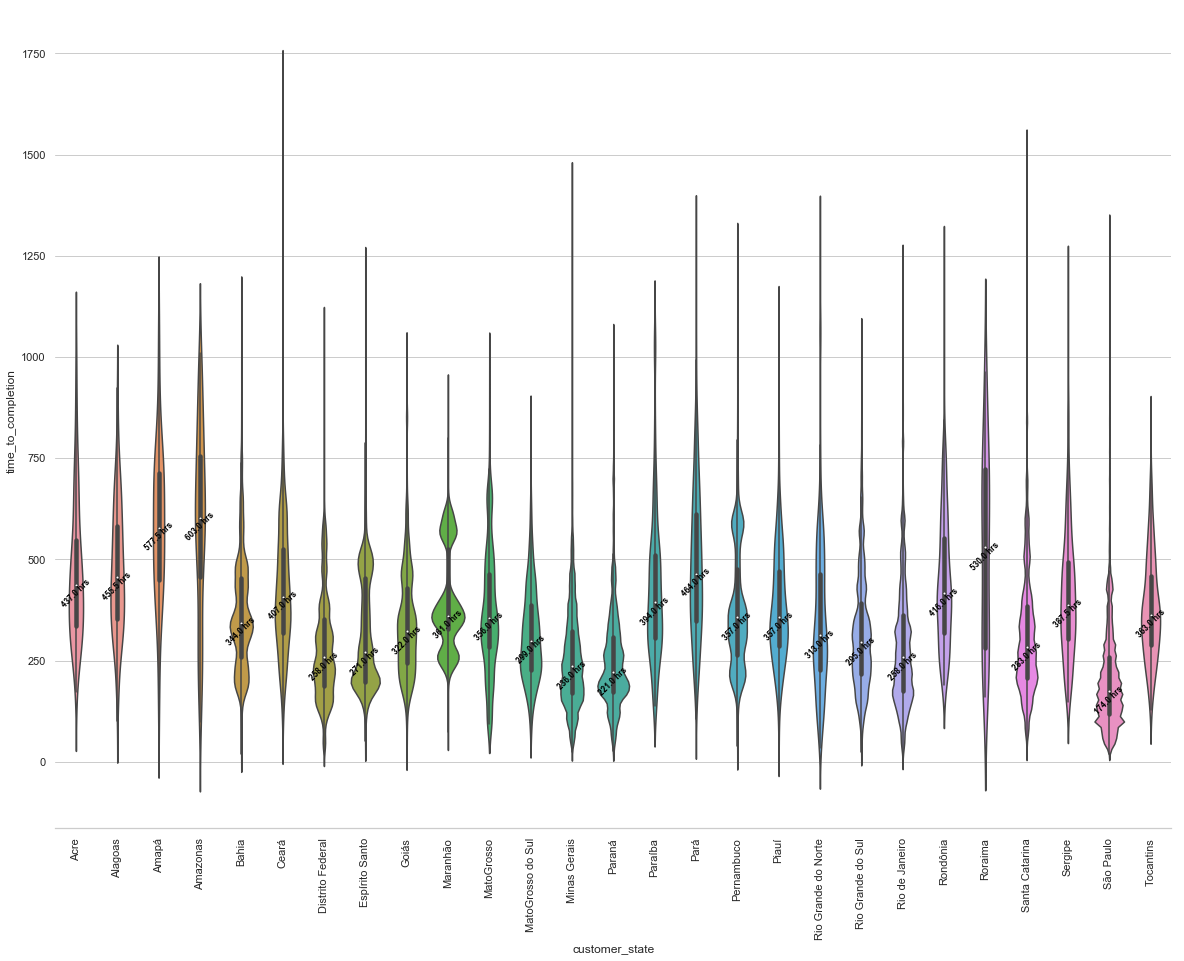

In [17]:
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)
act_medians = seller_customer2.groupby(['customer_state'])['time_to_completion'].median().values
act_median_labels = [f'{m} hrs' for m in act_medians]
# Draw a nested violinplot and split the violins for easier comparison
ax_four = sns.violinplot(x="customer_state", y="time_to_completion",data=seller_customer2,
                         order=['Acre','Alagoas','Amapá','Amazonas','Bahia',
                               'Ceará','Distrito Federal','Espírito Santo','Goiás','Maranhão',
                               'MatoGrosso','MatoGrosso do Sul','Minas Gerais','Paraná','Paraíba',
                               'Pará','Pernambuco','Piauí','Rio Grande do Norte','Rio Grande do Sul',
                               'Rio de Janeiro','Rondônia','Roraima','Santa Catarina','Sergipe',
                               'São Paulo','Tocantins'])
sns.despine(left=True)
pos2 = range(len(act_medians))
for tick,label in zip(pos2,ax_four.get_xticklabels()):
  ax_four.text(pos2[tick],act_medians[tick]+0.5,act_median_labels[tick],
         horizontalalignment='center',size='x-small',color='black',weight='semibold',rotation=45)
sns.set(rc={'figure.figsize':(20,15)})
ax_four.set_xticklabels(ax_four.get_xticklabels(),rotation=90)


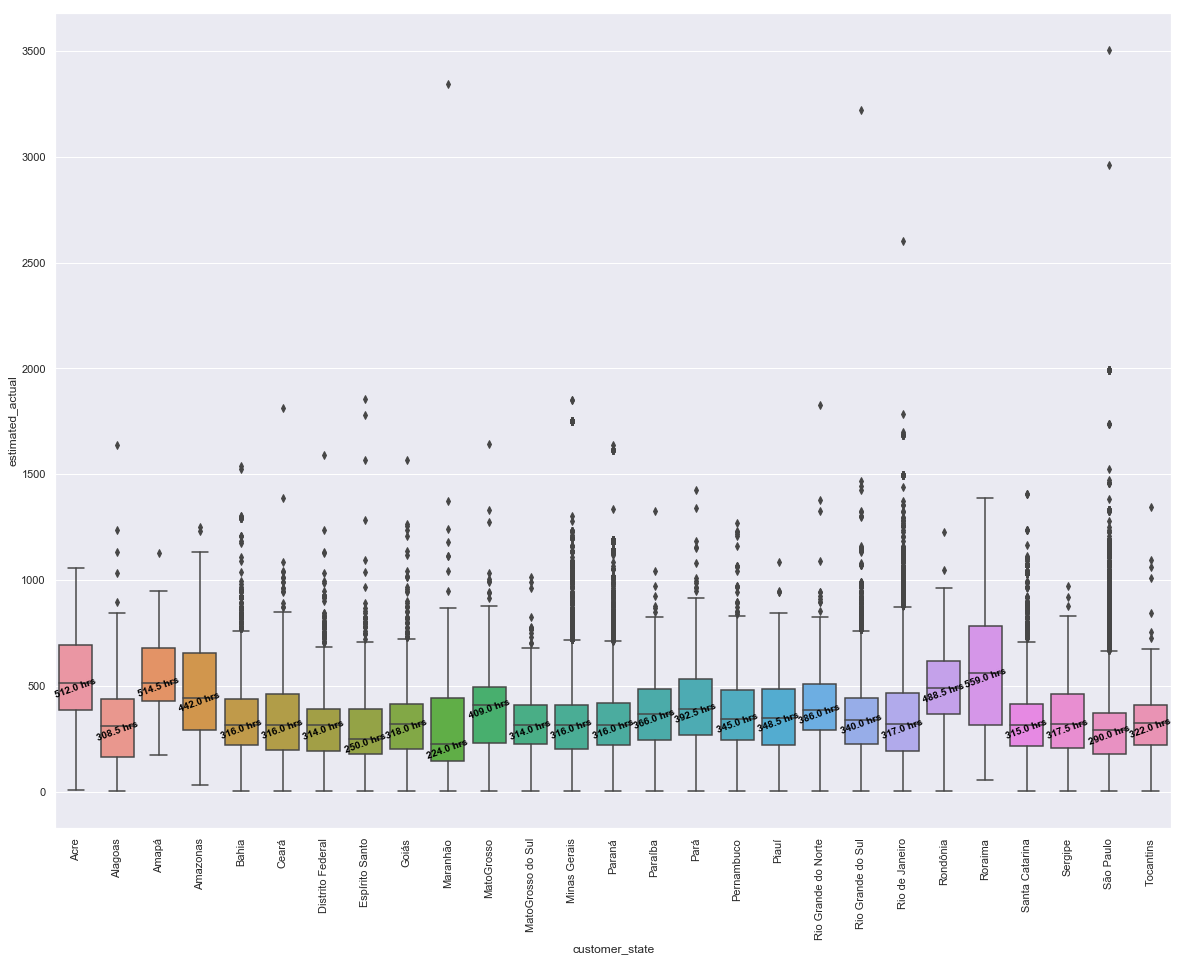

In [18]:
#delta between estimated and actual delivery times
ax_five = sns.boxplot(x="customer_state", y="estimated_actual",data=seller_customer2,
                     order=['Acre','Alagoas','Amapá','Amazonas','Bahia',
                               'Ceará','Distrito Federal','Espírito Santo','Goiás','Maranhão',
                               'MatoGrosso','MatoGrosso do Sul','Minas Gerais','Paraná','Paraíba',
                               'Pará','Pernambuco','Piauí','Rio Grande do Norte','Rio Grande do Sul',
                               'Rio de Janeiro','Rondônia','Roraima','Santa Catarina','Sergipe',
                               'São Paulo','Tocantins'])
est_medians =  seller_customer2.groupby(['customer_state'])['estimated_actual'].median().values
est_median_labels = [f'{m} hrs' for m in est_medians]
pos3 = range(len(est_medians))
for tick,label in zip(pos3,ax_five.get_xticklabels()):
  ax_five.set_xticklabels(ax_five.get_xticklabels(),rotation=90)
  ax_five.text(pos3[tick],est_medians[tick]+0.5,est_median_labels[tick],
         horizontalalignment='center',size='small',color='black',weight='semibold',rotation=20)
sns.set(rc={'figure.figsize':(20,15)})


In [0]:
#column of number of purchases made
seller_customer['no_purchases'] = seller_customer.groupby('customer_id')['customer_id'].transform('count')

In [0]:
reviews= pd.read_csv(r"/Users/emmanuelsibanda/Downloads/olist_order_reviews_dataset.csv")

In [0]:
seller_customer['order_id'] = seller_customer['order_id_x']


In [0]:
seller_customer=pd.merge(seller_customer,reviews,on='order_id',how='outer').fillna(0)

# Logistic regression to predict likelihood to purchase more than once

In [0]:
#create column for repeat and non repeat purchases
seller_customer['repeat'] = seller_customer['no_purchases'].apply(lambda x: 1 if x > 1 else 0)


In [0]:
#categorical to numerical
seller_customer['customer_city'] = seller_customer['customer_city'].astype('category')
seller_customer['customer_city'] = seller_customer['customer_city'].cat.codes
#origin to numerical
seller_customer['origin'] = seller_customer['origin'].astype('category')
seller_customer['origin'] = seller_customer['origin'].cat.codes
#lead behaviour profile
seller_customer['lead_type']=seller_customer['lead_type'].astype('category')
seller_customer['lead_type']=seller_customer['lead_type'].cat.codes

In [0]:
#removing purchase dates with value 0
seller_customer_clean = seller_customer[seller_customer['order_purchase_timestamp'] != 0]

In [0]:
seller_customer_sorted = seller_customer_clean.sort_values(by='order_purchase_timestamp')

In [0]:
#drop duplicates in rows 
seller_customer_sorted.drop_duplicates(subset ="customer_id",keep = 'first', inplace = True) 

In [0]:
seller_customer_sorted = seller_customer_sorted.drop('zip_code', 1)



In [29]:
#draw up correlation matrix
corr = seller_customer_sorted.corr()
corr.style.background_gradient(cmap='coolwarm')

,lead_type,declared_product_catalog_size,declared_monthly_revenue,origin,order_item_id,price,freight_value,days_to_close,customer_city,usd_price,purchase_to_approval,time_to_completion,estimated_actual,no_purchases,review_score,repeat
lead_type,1,0.0649492,0.006837,0.463874,0.174552,0.0764025,0.144137,0.0469051,0.0104905,0.0764025,0.00115088,0.00091695,-0.0010406,0.0103427,0.239399,0.198361
declared_product_catalog_size,0.0649492,1,0.0109077,0.0376677,-0.00698481,-0.00368215,-0.00583386,0.00426014,-0.0218305,-0.00368215,0.000518709,0.00224096,-0.00234495,-0.00152769,-0.00803777,-0.00734584
declared_monthly_revenue,0.006837,0.0109077,1,0.00720239,-0.00185019,-0.000975357,-0.00154532,0.00110243,-0.00578266,-0.000975357,0.0001374,0.000593605,-0.000621151,-0.000404667,-0.00212911,-0.00194583
origin,0.463874,0.0376677,0.00720239,1,-0.00658615,-0.00776051,-0.00338804,-0.72604,-0.310586,-0.00776051,0.00885476,0.0343752,-0.0359529,-0.0157212,0.0129894,0.00882632
order_item_id,0.174552,-0.00698481,-0.00185019,-0.00658615,1,0.304692,0.512671,0.132881,-0.0166304,0.304692,0.00161,0.00801124,-0.00840536,0.147485,0.711518,0.669319
price,0.0764025,-0.00368215,-0.000975357,-0.00776051,0.304692,1,0.621441,0.0700105,0.0208298,1,-0.000771342,0.00474225,-0.0047881,0.0443284,0.382533,0.35828
freight_value,0.144137,-0.00583386,-0.00154532,-0.00338804,0.512671,0.621441,1,0.110966,0.00690956,0.621441,0.000449645,0.00513407,-0.00526168,0.0998892,0.608711,0.582593
days_to_close,0.0469051,0.00426014,0.00110243,-0.72604,0.132881,0.0700105,0.110966,1,0.414568,0.0700105,-0.00984407,-0.0425426,0.0445173,0.029015,0.15297,0.139726
customer_city,0.0104905,-0.0218305,-0.00578266,-0.310586,-0.0166304,0.0208298,0.00690956,0.414568,1,0.0208298,-0.00995621,-0.034894,0.035947,0.0196877,-0.00733317,0.0910623
usd_price,0.0764025,-0.00368215,-0.000975357,-0.00776051,0.304692,1,0.621441,0.0700105,0.0208298,1,-0.000771342,0.00474225,-0.0047881,0.0443284,0.382533,0.35828


In [0]:
#drop unneeded columns
seller_customer_sorted = seller_customer_sorted.drop(columns=['declared_product_catalog_size','declared_monthly_revenue'])

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
#defining features and target
X = seller_customer_sorted[['origin','review_score','freight_value']].values
y = seller_customer_sorted['repeat'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logisticModel = LogisticRegression()
#training data with logistic regression model
logisticModel.fit(X_train,y_train)
#predicting with models
predicts = logisticModel.predict(X_test)


In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predicts))
print("Accuracy:", accuracy_score(y_test, predicts)) 

             precision    recall  f1-score   support

          0       0.95      0.93      0.94     25799
          1       0.78      0.83      0.81      7416

avg / total       0.91      0.91      0.91     33215

Accuracy: 0.9104621405991269


## Very high accuracy, running 10-fold cross validation to verify this result

In [0]:
from sklearn.model_selection import KFold, cross_val_score
#defining features and target
kfold = KFold(n_splits=10,shuffle=True,random_state=0)
scores = []
for train_index, test_index in kfold.split(X):
  print("Train Index:", train_index, "\n")
  print("Test Index:", test_index)
  X_train,X_test,y_train,y_test = X[train_index],X[test_index],y[train_index],y[test_index]
  logit.fit(X_train,y_train)
  scores.append(logit.score(X_test,y_test))

In [0]:
print("Accuracy: {}%".format(np.mean(scores)*100))
print("Variance: {}".format(np.var(scores)))